In [5]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

## 1 - Data loading and cleaning
We first load the csv file into a panda dataframe and drop every row with missing information (i.e. a null value)

In [7]:
data = pd.read_csv("datasets/nba_logreg.csv")
data = data.dropna()
data.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


#### Visualisation of the data and balancing
In this step we get the number of players classified in both categories. We realise that the data is already quite balanced and doesn't necessarily require balancing.

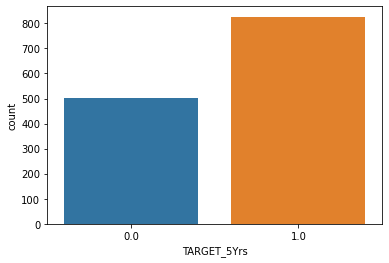

In [8]:
seaborn.countplot(x="TARGET_5Yrs", data=data)
plt.show()

#### Data insight
We group each row by category, intuitivly the mean stats of the player who play in the nba for more than 5 years in the nba are higher

Rookie ending up playing more than 5 years play more, score more, get more rebounds, assists.

#### Counter-intuitive observations
- 3P% : We notice that rookies classified as 1 have a slightly worst 3 points percentage on average but a bigger 3 points attempts number. Which means that rookies ending up being successful in the nba seems to attemps more 3 points even though it doesn't always pay up.

- TOV : Also the number of turn-overs is higher for rookies classified as 1, which means they lose the ball more. This is likely correlated with the fact that they play more in average and then get more chance to lose the ball during the match.

In [9]:
data.groupby('TARGET_5Yrs').mean()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
TARGET_5Yrs,,,,,,,,,,,,,,,,,,,
0.0,51.495030,14.276740,5.060636,1.951093,4.562425,42.270775,0.232406,0.763618,19.378131,0.928231,1.324254,69.122266,0.713519,1.522863,2.234592,1.230815,0.500000,0.249901,0.944732
1.0,65.826877,19.700847,7.891646,3.051090,6.718523,45.242131,0.260169,0.799031,19.265496,1.530872,2.133656,71.189588,1.186683,2.325061,3.511864,1.758838,0.693705,0.436925,1.349031


#### Determining good predictors
We draw a distribution graph for every variable and compare the distribution for players classified as 0 and the ones classified as 1.
We then redraw each graph which seems to indicate a good predictor.

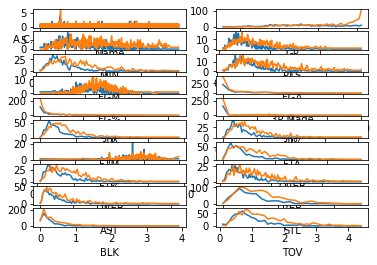

In [10]:
plot_per_line = 2

nbr_rows = len(data.columns) // plot_per_line

for i in range(len(data.columns) - 1):
    ax = plt.subplot(nbr_rows, plot_per_line, (i + 1))
    pd.crosstab(data[data.columns[i]], data.TARGET_5Yrs).plot(ax=ax, legend=None)

plt.show()

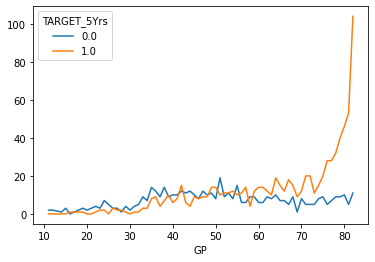

In [11]:
pd.crosstab(data.GP, data.TARGET_5Yrs).plot()
plt.show()

The number of game played seems to be a good predictor when the number of game played is more than 75

#### More data cleaning and normalizing
We remove the name column which is meaningless for our model, we also normalize the data using the sklearn library. Finally we split our data into training and test data.

In [16]:
from sklearn import preprocessing

# Select the data
X = data.loc[:, data.columns != "TARGET_5Yrs"]

# Select the labels
y = data["TARGET_5Yrs"]

# Remove the name column
X = X.loc[:, X.columns != "Name"]

# Normalize the data
X = (X - X.mean()) / X.std()

In [18]:
from imblearn.over_sampling import SMOTE

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

os = SMOTE(random_state=0)
os_X_train, os_y_train = os.fit_resample(X_train, y_train)
os_X_test, os_y_test = os.fit_resample(X_test, y_test)
X_train = pd.DataFrame(data=os_X_train, columns=X_train.columns)
y_train = pd.DataFrame(data=os_y_train, columns=["TARGET_5Yrs"])
#X_test = pd.DataFrame(data=os_X_test, columns=X_test.columns)
#y_test = pd.DataFrame(data=os_y_test, columns=["TARGET_5Yrs"])

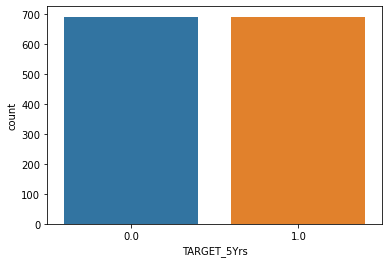

(1380, 19)
(200, 19)


In [19]:
one_count = y_train.sum()
zero_count = len(y_train) - one_count

seaborn.countplot(x="TARGET_5Yrs", data=y_train)
plt.show()

print(X_train.shape)
print(X_test.shape)

#### Meaningful features selection
First we use the statsmodels library to perform logistic regression from a statistic point of view. This library will compute p-values for us and determine which feature are considered significant.

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

logit_model = sm.Logit(np.asarray(y_train), X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.567486
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.181     
Dependent Variable: y                AIC:              1604.2621 
Date:               2022-01-08 00:19 BIC:              1703.6290 
No. Observations:   1380             Log-Likelihood:   -783.13   
Df Model:           18               LL-Null:          -956.54   
Df Residuals:       1361             LLR p-value:      1.0366e-62
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
GP         0.6402     0.0840    7.6195   0.0000    0.4756    0.8049
MIN       -0.4691     0.2697   -1.7394   0.0820   -0.9978 

#### Interpretation of p-values

p-values above 0.05 are not considered statistically significant, hence we can remove the following features MIN, PTS, FGM, 3P%, FTM, FTA, FT%, OREB, DREB, REB, STL, TOV


We can also notice that our insight that the feature GP (number of Games Played) will make a good predictor was right. As a matter of fact its p-value is 0.00000. Also the 3P% and TOV are bad predictors as expected (with p-value higher 0.05 hence not statistically significant).

In [22]:
# we only select these features :
features = ["GP", "MIN", "FGA", "FG%", "3P Made", "3PA", "FT%", "AST", "BLK"]

X_train = X_train[features]
X_test = X_test[features]

# Split data into training and test data with the new data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

logit_model = sm.Logit(np.asarray(y_train), X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.577260
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.167     
Dependent Variable: y                AIC:              1611.2380 
Date:               2022-01-08 00:19 BIC:              1658.3066 
No. Observations:   1380             Log-Likelihood:   -796.62   
Df Model:           8                LL-Null:          -956.54   
Df Residuals:       1371             LLR p-value:      2.4412e-64
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
GP         0.6167     0.0825    7.4778   0.0000    0.4551    0.7783
MIN       -0.1390     0.1952   -0.7120   0.4765   -0.5216 

## 2 - Model fitting
Now that the data is cleaned, and only meaningful features are selected, we can run the logistic regression algorithm with the sklearn.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))

0.705


C:\Users\Paul\miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## 3 - Model evaluation
We compute the confusion matrix, precision, recall and f1-score.

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
print(confusion_matrix)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity : ", sensitivity)
print("Specificity : ", specificity)

[[49 15]
 [44 92]]
Sensitivity :  0.6764705882352942
Specificity :  0.765625


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.77      0.62        64
         1.0       0.86      0.68      0.76       136

    accuracy                           0.70       200
   macro avg       0.69      0.72      0.69       200
weighted avg       0.75      0.70      0.71       200



#### Interpretation of precision and recall for our model

Recall is a way higher for class 0 than class 1 which means our classifier might do a better job at catching all unsuccessful players insthead of successful ones but half of the players classified as successful might be successful.

For class 1 precision is very high which means that our classifier will most likely be correct when classifying a player as successful but might not catch all of them.

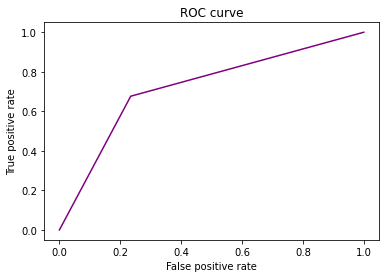

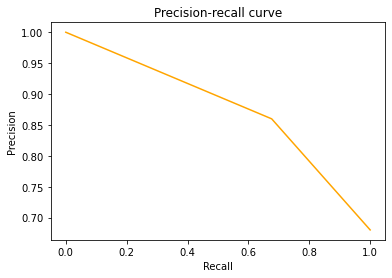

In [37]:
# Calculate ROC curve
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="purple")
plt.show()

# Calculate precision-recall curve
plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, color="orange")
plt.show()

## 4 - Using the classifier to predict success of 2020-2021 rookies in the NBA
First we download statistics of 2021 rookies for the 2020-2021 season at https://www.basketball-reference.com/leagues/NBA_2021_per_game.html



In [260]:
data2 = pd.read_csv("datasets/2020_rookies.csv")
data2.rename(columns={"G": "GP", "MP": "MIN", "3P": "3P Made"}, inplace=True)

data2 = data2.dropna()
X2 = data2[features]

X2 = (X2 - X2.mean()) / X2.std()

y_pred = pd.Series(logreg.predict(X2))
preds = pd.concat([data2["Player"], y_pred], axis=1)
preds = preds.dropna()


print(preds.head(20))

                                Player    0
0           Precious Achiuwa\achiupr01  1.0
2               Steven Adams\adamsst01  1.0
3                Bam Adebayo\adebaba01  1.0
4          LaMarcus Aldridge\aldrila01  1.0
5          LaMarcus Aldridge\aldrila01  1.0
6          LaMarcus Aldridge\aldrila01  0.0
7          Ty-Shon Alexander\alexaty01  1.0
8   Nickeil Alexander-Walker\alexani01  1.0
9              Grayson Allen\allengr01  1.0
10             Jarrett Allen\allenja01  1.0
12             Jarrett Allen\allenja01  0.0
13           Al-Farouq Aminu\aminual01  0.0
14           Al-Farouq Aminu\aminual01  1.0
15           Al-Farouq Aminu\aminual01  1.0
16             Kyle Anderson\anderky01  1.0
17     Giannis Antetokounmpo\antetgi01  1.0
19    Thanasis Antetokounmpo\antetth01  1.0
20           Carmelo Anthony\anthoca01  0.0
21              Cole Anthony\anthoco01  0.0
22                OG Anunoby\anunoog01  1.0


## 5 - Conclusion
During the model evaluation we observed a very high precision for class 1 which means that if our model classify a player as 0 then he will most likely be successful. On the other hand precision is very low for class 0 so we cannot draw any conclusion on a player carrer if he is classified as 0 by our model.